## Reading the PARSIVEL and MRR-PRO data from the ingested data. 

The OTT $Parsivel^2$ is a laser disdrometer that obtains the rain drop size distributions via a particle counter. The size and fall speed of the particles is determined through the scattering signal from raindrops. 

The data are automatically ingested and stored on GCE for each day at:
    '/nfs/gce/projects/crocus/data/ingested-data/field-campaigns/crocus-rainfall/parsivel*'

The easiest way to download the data from GCE is to do so using Globus. If you have an Argonne account and GCE access, then you can access the CROCUS data from the CELS GCE Endpoint.

The data are stored in netCDF files that contain the drop size distributions and fall velocities for comparison against the MRR-PRO. 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cmweather
import numpy as np
import glob

Load the Parsivel data

In [2]:
parsivel_ds = xr.open_dataset('../../data/parsivel/crocus.adm.parsivel.20250315.000000.a1.nc')

ERROR 1: dlopen(/Users/rjackson/mambaforge/envs/pydda_env/lib/gdalplugins/ogr_PG.dylib, 0x0001): Library not loaded: /usr/lib/libpq.5.dylib
  Referenced from: <59CCB516-6965-3A3D-B4E6-E63EAD784F4C> /Users/rjackson/mambaforge/envs/pydda_env/lib/gdalplugins/ogr_PG.dylib
  Reason: tried: '/usr/lib/libpq.5.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/lib/libpq.5.dylib' (no such file), '/usr/lib/libpq.5.dylib' (no such file, not in dyld cache), '/usr/local/lib/libpq.5.dylib' (no such file)
ERROR 1: dlopen(/Users/rjackson/mambaforge/envs/pydda_env/lib/gdalplugins/ogr_PG.dylib, 0x0001): Library not loaded: /usr/lib/libpq.5.dylib
  Referenced from: <59CCB516-6965-3A3D-B4E6-E63EAD784F4C> /Users/rjackson/mambaforge/envs/pydda_env/lib/gdalplugins/ogr_PG.dylib
  Reason: tried: '/usr/lib/libpq.5.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/lib/libpq.5.dylib' (no such file), '/usr/lib/libpq.5.dylib' (no such file, not in dyld cache), '/usr/local/lib/libpq.5.dy

Let's take a look at what's in the file!

In [3]:
parsivel_ds

<xarray.Dataset> Size: 1MB
Dimensions:                      (time: 1440, bin_edges: 33, bins: 32)
Coordinates:
  * time                         (time) datetime64[ns] 12kB 2025-03-14T23:55:...
  * bin_edges                    (bin_edges) float64 264B 0.0 0.1245 ... 26.78
  * bins                         (bins) float64 256B 0.06225 0.1895 ... 25.24
Data variables: (12/23)
    velocity                     (time, bins) float64 369kB ...
    Nd                           (time, bins) float64 369kB ...
    num_particles                (time) int64 12kB ...
    spectrum_fall_velocity       (time, bins) float64 369kB ...
    rain_rate                    (time) float64 12kB ...
    D0                           (time) float64 12kB ...
    ...                           ...
    power_supply_voltage         (time) float64 12kB ...
    sensor_head_heating_current  (time) float64 12kB ...
    sensor_heating_temperature   (time) int64 12kB ...
    temperature_right_head       (time) int64 12kB ...
    temperature_left_head        (time) int64 12kB ...
    sensor_time                  (time) datetime64[ns] 12kB ...
Attributes:
    site:                Argonne Deployable Mast
    mentors:             Liz Wawrzyniak, Joseph O'Brien, Bobby Jackson, Bhupe...
    mentor_emails:       ewawrzyniak@anl.gov, obrien@anl.gov, rjackson@anl.go...
    mentor_institution:  Argonne National Laboratory
    mentor_orcids:       0000-0003-4655-6912, 0000-0003-2518-1234
    contributors:        Scott Collis, Paytsar Muradyan, Max Grover, Matt Tuf...

Let's plot the rain rates from the Parsivel.

Text(0.5, 0, 'Time [UTC]')

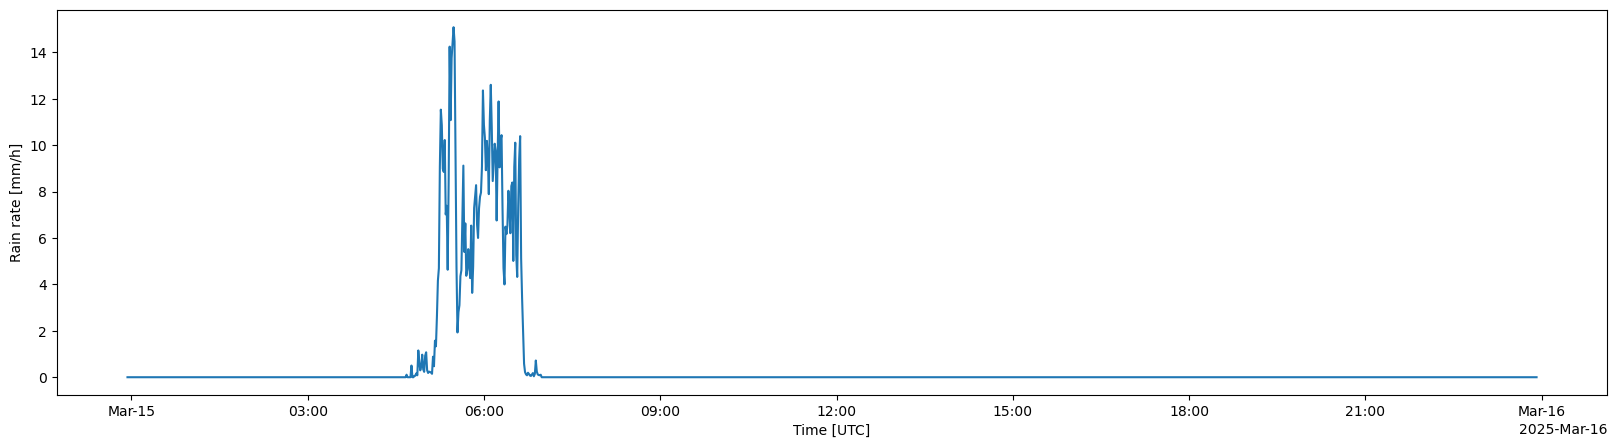

In [4]:
plt.figure(figsize=(20, 5))
parsivel_ds['rain_rate'].T.plot()
plt.xlabel('Time [UTC]')

As you can see here, we have one period of precipitation. This case is from an overnight QLCS that affected the Chicago region. We can see over 1 cm/hr rainfall rates which would indicate moderate rainfall intensity.

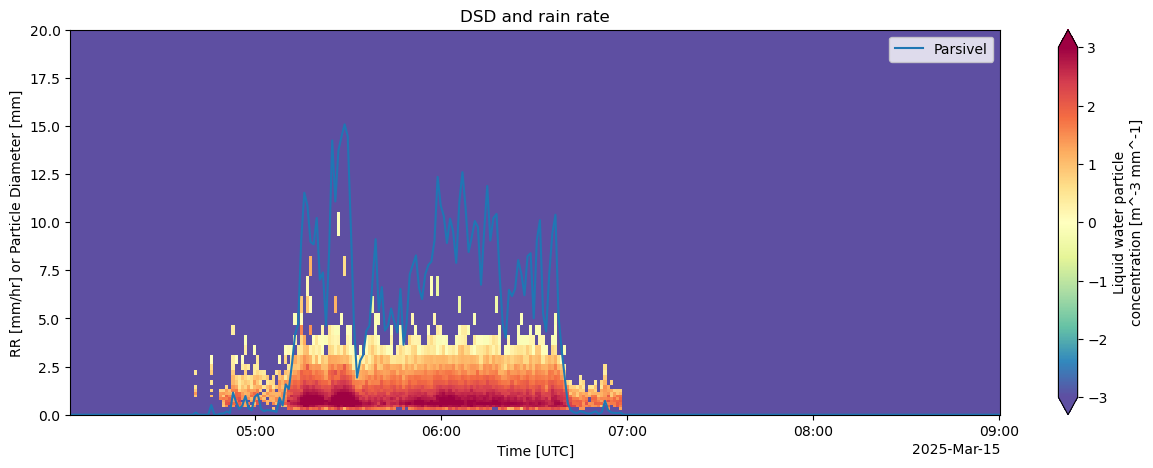

In [7]:
plt.figure(figsize=(15, 5))
np.log10(parsivel_ds['Nd']).sel(time=slice('2025-03-15T04:00:00', '2025-03-15T09:00:00')).T.plot(vmin=-3, vmax=3, cmap='Spectral_r')
parsivel_ds['rain_rate'].sel(time=slice('2025-03-15T04:00:00', '2025-03-15T09:00:00')).T.plot(label='Parsivel')
plt.ylim([0, 20])
plt.ylabel('RR [mm/hr] or Particle Diameter [mm]')
plt.xlabel('Time [UTC]')
plt.legend()
plt.title("DSD and rain rate")
plt.savefig('dsd_rain_rate.png', bbox_inches='tight')

The rainfall here is dominated by < 2 mm drops, as we would expect. However, there are some isolated > 5 mm drops. Drops > 5 mm in diameter are relatively rare, so it is worth investigating if these could be splashing artifacts or perhaps artifacts due to tilting of the raindrop in strong winds. To do this, we look at the recorded fall velocities.

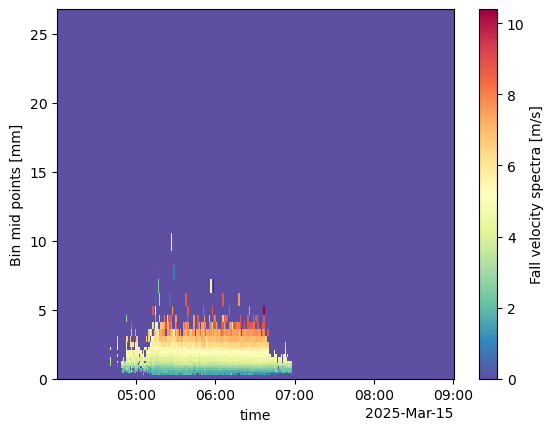

In [13]:
parsivel_ds['spectrum_fall_velocity'].sel(
    time=slice('2025-03-15T04:00:00', '2025-03-15T09:00:00')).T.plot(vmin=0, cmap='Spectral_r')

From this plot, some of the larger drops have lower velocities than the 4 mm drops, which is unexpected if the droplet were falling from the sky at its terminal velocity. This therefore could be splashing or an artifact of the drop tilting in strong winds. The wind gusts on this day were on the order of 55-65 mph, so tilting is definitely a possibility.

One common QC filter is to filter out bins whose recorded velocities are not within 50% of the expected terminal velocity. Let's find out which drops are within that 50% range.

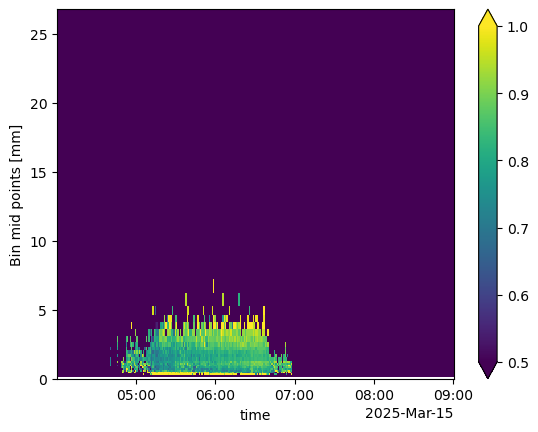

In [8]:
velocity_ratio = parsivel_ds['spectrum_fall_velocity']/parsivel_ds["velocity"]
velocity_ratio.sel(
    time=slice('2025-03-15T04:00:00', '2025-03-15T09:00:00')).T.plot(vmin=0.5, vmax=1)

Filtering the above, we see a much cleaner dataset.

(0.0, 20.0)

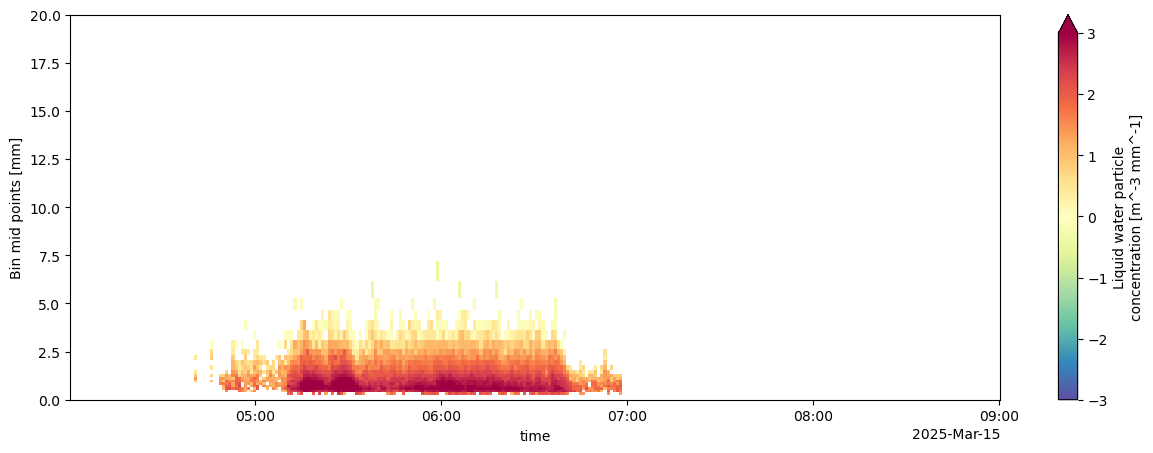

In [10]:
plt.figure(figsize=(15, 5))
np.log10(parsivel_ds['Nd']).where(
    np.logical_and(velocity_ratio > 0.5, velocity_ratio < 1.5)).sel(
    time=slice('2025-03-15T04:00:00', '2025-03-15T09:00:00')).T.plot(vmin=-3, vmax=3, cmap='Spectral_r')
plt.ylim([0, 20])

Let's recalculate the rainfall rates!

In [45]:
def calc_rainfall_rate(number_distribution, velocity, bin_edges):
    """
    Calcualtes the rainfall rate from a number distribution
    """
    spread = xr.DataArray(bin_edges.diff(dim='bin_edges').values, dims=['bins']).values
    diameter = xr.DataArray(np.tile(number_distribution["bins"].values,
                     (number_distribution.sizes["time"], 1)), dims=['time', 'bins'])
    summation = spread * velocity  * number_distribution * (diameter)**3
    rr = np.pi * 0.6 * 1e-3 * summation.sum(dim='bins')
    rr.attrs["long_name"] = "Rainfall rate"
    rr.attrs["units"] = "mm hr-1"
    
    return rr
    
parsivel_ds["Nd_filtered"] = parsivel_ds['Nd'].where(
    np.logical_and(velocity_ratio > 0.7, velocity_ratio < 1.3))

parsivel_ds["rr_filtered"] = calc_rainfall_rate(parsivel_ds["Nd_filtered"], parsivel_ds["spectrum_fall_velocity"],
                                               parsivel_ds["bin_edges"])

In [46]:
parsivel_ds["bin_edges"].values

array([ 0.    ,  0.1245,  0.2545,  0.3845,  0.5145,  0.6445,  0.7745,
        0.9045,  1.0245,  1.1545,  1.2845,  1.5485,  1.7985,  2.0585,
        2.3185,  2.5785,  3.0875,  3.6075,  4.1175,  4.6375,  5.1475,
        6.175 ,  7.215 ,  8.235 ,  9.275 , 10.295 , 12.36  , 14.42  ,
       16.48  , 18.54  , 20.6   , 23.695 , 26.785 ])

Let's look at the recalculated rainfall rates!

Going by the fact that the filtered rainfall rates are higher than manufacturer provided, this tells us that the Parsivel has internal QC for filtering out splashing artifacts.

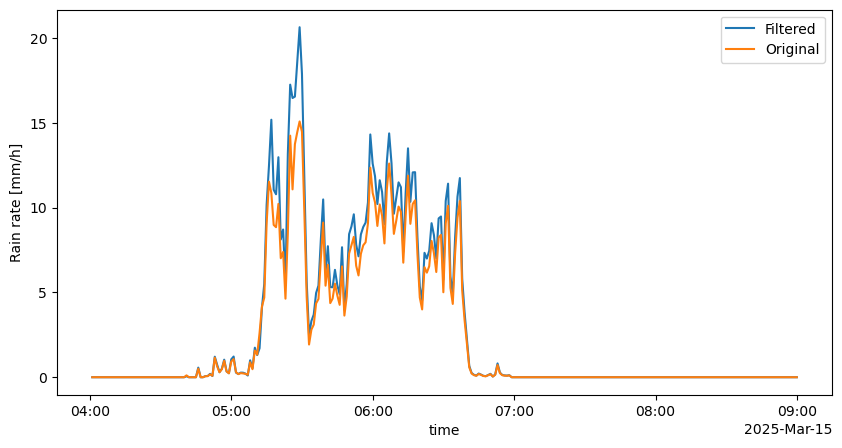

In [50]:
plt.figure(figsize=(10, 5))
parsivel_ds["rr_filtered"].sel(
    time=slice('2025-03-15T04:00:00', '2025-03-15T09:00:00')).plot(label='Filtered')
parsivel_ds["rain_rate"].sel(
    time=slice('2025-03-15T04:00:00', '2025-03-15T09:00:00')).plot(label='Original')
plt.legend()